# Proyecto

modificar el mapeo en base al data set.
https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification?select=predictive_maintenance.csv

Revisar  los hiper parametros de regresion para regulizacion en xgboost de regresion, verificar y ajustar hiperparametros de clasificacion.

Ver como hacer un balanceo en el nuevo de clasificacion

En regresión, lo que más se utiliza es el promedio de las predicciones de los modelos base (votación suave).

modificar predicciones

## Descripción del proyecto.


Participantes:


*   Elemento de la lista
*   Elemento de la lista
*   Elemento de la lista



## **Librerías Importadas**

In [176]:
# Librerías para manejo de datos.
import pandas as pd
import numpy as np

# Librería para visualización de datos.
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para escalado y estandarización.
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Librerías para división de datos (entrenamiento y prueba).
from sklearn.model_selection import train_test_split

# Librerías para Modelos de Aprendizaje para regresion
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor

# Librerías para evaluación para regresion
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Libreria para generar datos sinteticos
from imblearn.over_sampling import SMOTE

# Librerías para Modelos de Aprendizaje para clasificación
from sklearn.ensemble import RandomForestClassifier

# Librerías para evaluación para regresion
from sklearn.metrics import accuracy_score, classification_report


## **Carga y Exploración del Dataset**

### *Carga del dataset*

In [177]:
# Importamos nuestro dataset
data = pd.read_csv("predictive_maintenance.csv")

### Filas y Columnas

In [178]:
data.head()

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure

### Informacion del dataset

In [179]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


### Descripcion

In [180]:
data.describe()

UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000           301.500000               311.100000   
max    10000.00000           304.500000               313.800000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [min]        Target  
count            10000.000000  10000.000000     10000.000000  10000.000000  
mean              1538.776100     39.986910       107.951000      0.033900  
std                179.284096      9.968934        63.654147      0.180981  
min               1168.000000      3.800000         0.000000      0.000000  
25%               1423.000000     33.200000        53.000000      0.000000  
50%               1503.000000     40.100000       108.000000      0.000000  
75%               1612.000000     46.800000       162.000000      0.000000  
max               2886.000000     76.600000       253.000000      1.000000

## **Análisis Exploratorio de Datos**

### *Cantidad de datos de nuestros targets*

Primero veremos con cuantos datos contamos en el caso de nuestro dos target que ocuparemos tanto de Failure Type como Target. En el caso de Target son cuantas maquinas tienen fallas y cuantas no.

In [181]:
data['Failure Type'].value_counts()

Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

Como vemos nuestros ***Targets*** parecen desbalanceados por lo que aplicaremos diferentes tecnicas para tratar con este desbalanceo y no afecte a nuestros modelos.

#### Grafica

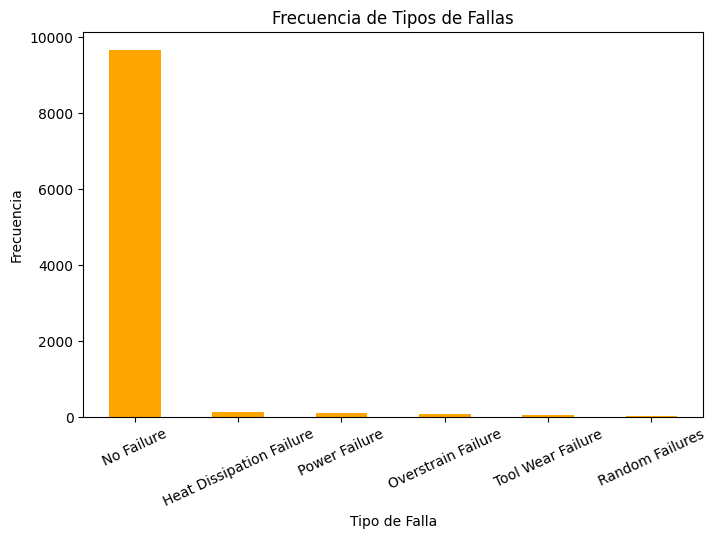

In [182]:
data['Failure Type'].value_counts().plot(kind='bar', color='orange', figsize=(8, 5))

# Etiquetas y título
plt.xlabel("Tipo de Falla")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de Tipos de Fallas")
plt.xticks(rotation=25)

# Mostrar la gráfica
plt.show()

In [183]:
data['Target'].value_counts()

Target
0    9661
1     339
Name: count, dtype: int64

#### Grafica

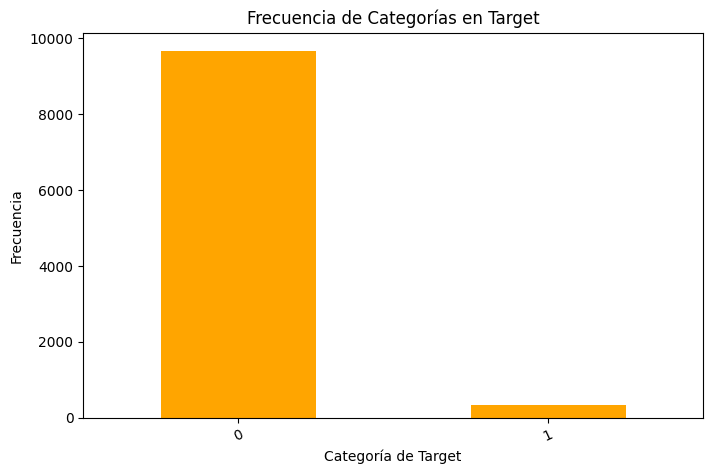

In [184]:
data['Target'].value_counts().plot(kind='bar', color='orange', figsize=(8, 5))

# Etiquetas y título
plt.xlabel("Categoría de Target")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de Categorías en Target")
plt.xticks(rotation=25)

# Mostrar la gráfica
plt.show()

Asi mmismo con este target, aplicaremos una tecnica que veremos mas adelante para el desbalanceo.

### *Features Plot*

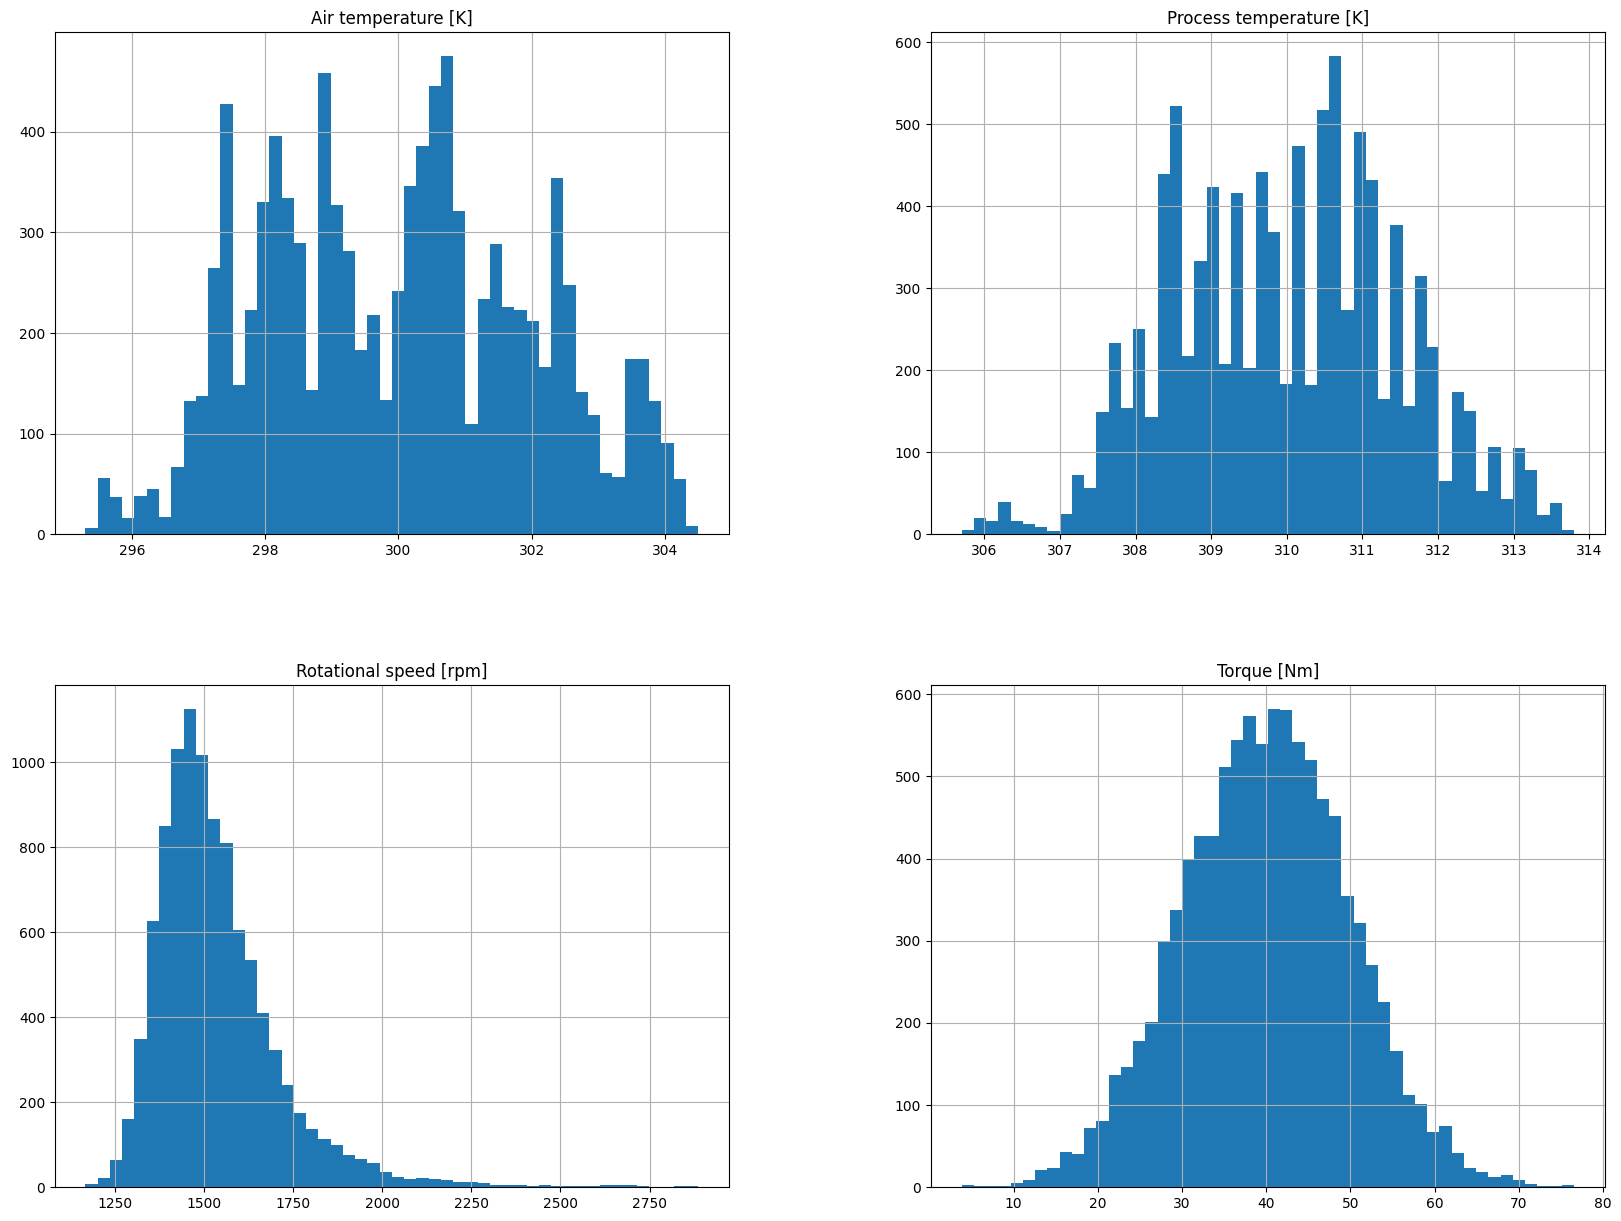

In [185]:
data[['Air temperature [K]','Process temperature [K]','Rotational speed [rpm]','Torque [Nm]']].hist(bins=50, figsize=(20,15))
plt.show()

# Mostrar el gráfico
plt.show()

### *Boxplot*

Ahora verificamos mediante boxplots para ver si hay valores atipicos, dato por dato.

El cual los colores **salmon** seran boxplots **sin valores** atipicos.

---

Y el color **rojo** seran boxplot **con valores** atipicos.

#### Temperatura del aire

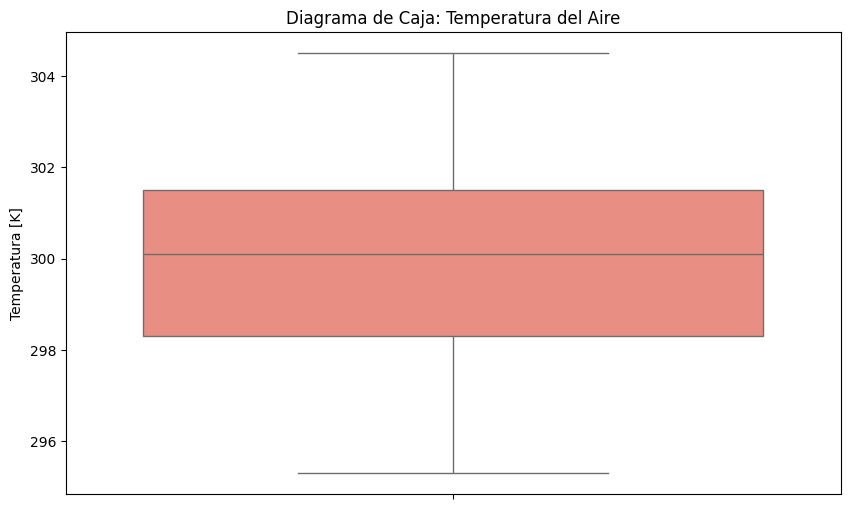

In [186]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un boxplot para visualizar valores atípicos en la temperatura del aire
plt.figure(figsize=(10, 6))
sns.boxplot(y=data['Air temperature [K]'], color='salmon')
plt.title('Diagrama de Caja: Temperatura del Aire')
plt.ylabel('Temperatura [K]')
plt.show()

*Sin valores atipicos*

#### Temperatura del proceso

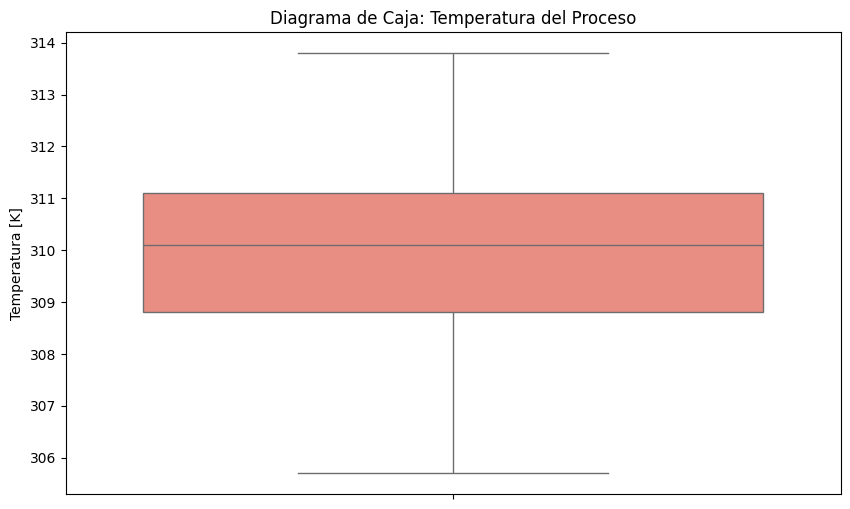

In [187]:
# Crear un boxplot para visualizar valores atípicos en la temperatura del proceso
plt.figure(figsize=(10, 6))
sns.boxplot(y=data['Process temperature [K]'], color='salmon')
plt.title('Diagrama de Caja: Temperatura del Proceso')
plt.ylabel('Temperatura [K]')
plt.show()

*Sin valores atipicos*

#### Velocidad rotacional

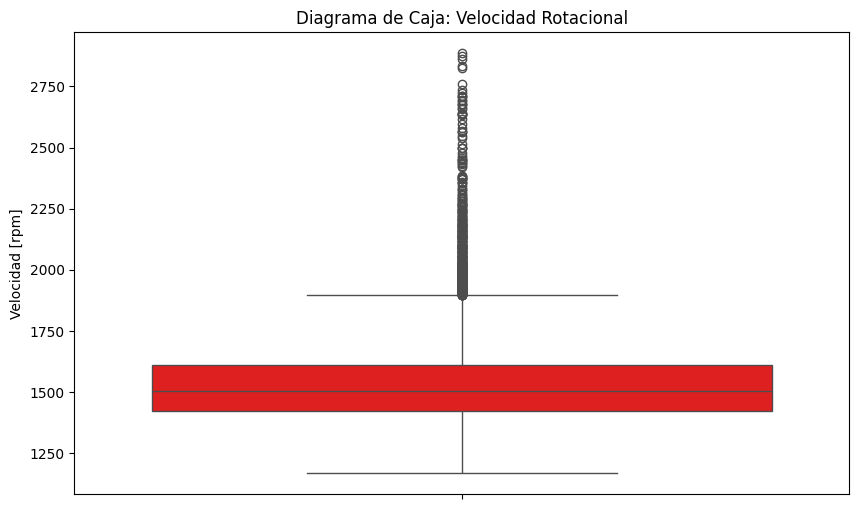

In [188]:
# Crear un boxplot para visualizar valores atípicos en la velocidad rotacional
plt.figure(figsize=(10, 6))
sns.boxplot(y=data['Rotational speed [rpm]'], color="red")
plt.title('Diagrama de Caja: Velocidad Rotacional')
plt.ylabel('Velocidad [rpm]')
plt.show()

*Con valores atipicos*

In [189]:
# Calcular cuartiles e IQR
Q1, Q3 = data['Rotational speed [rpm]'].quantile([0.25, 0.75])
IQR = Q3 - Q1

# Definir límites de valores atípicos
lim_inf, lim_sup = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

# Identificar valores atípicos
outliers = (data['Rotational speed [rpm]'] < lim_inf) | (data['Rotational speed [rpm]'] > lim_sup)
num_outliers = outliers.sum()

# Reemplazar valores atípicos
data['Rotational speed [rpm]'] = data['Rotational speed [rpm]'].clip(lim_inf, lim_sup)
num_reemplazados = num_outliers  # Ya que cada outlier se reemplaza

# Mostrar resultados
print(f"Cantidad de valores atípicos detectados: {num_outliers}")
print(f"Cantidad de valores reemplazados: {num_reemplazados}")

Cantidad de valores atípicos detectados: 418
Cantidad de valores reemplazados: 418


#### Torque

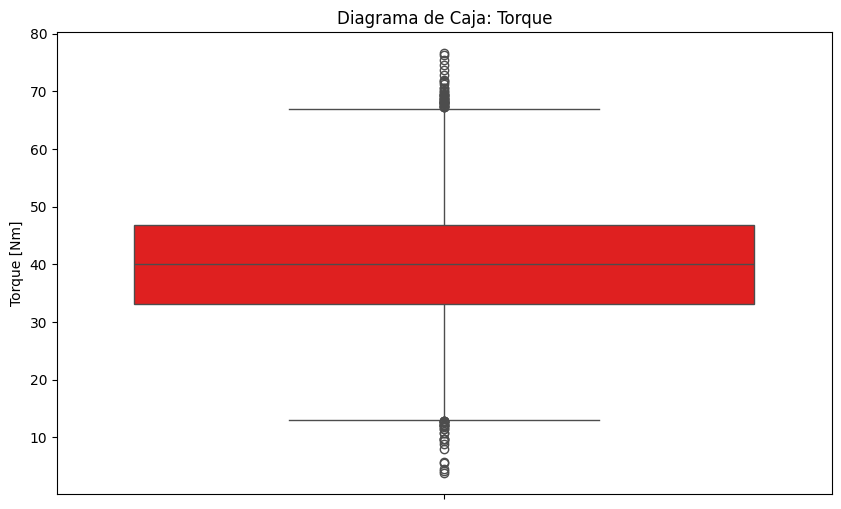

In [190]:
# Crear un boxplot para visualizar valores atípicos en el torque
plt.figure(figsize=(10, 6))
sns.boxplot(y=data['Torque [Nm]'], color='red')
plt.title('Diagrama de Caja: Torque')
plt.ylabel('Torque [Nm]')
plt.show()

*Con valores atipicos*

In [191]:
# Calcular cuartiles e IQR
Q1, Q3 = data['Torque [Nm]'].quantile([0.25, 0.75])
IQR = Q3 - Q1

# Definir límites de valores atípicos
lim_inf, lim_sup = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

# Identificar valores atípicos
outliers = (data['Torque [Nm]'] < lim_inf) | (data['Torque [Nm]'] > lim_sup)
num_outliers = outliers.sum()

# Reemplazar valores atípicos
data['Torque [Nm]'] = data['Torque [Nm]'].clip(lim_inf, lim_sup)
num_reemplazados = num_outliers  # Cada outlier es reemplazado

# Mostrar resultados
print(f"Cantidad de valores atípicos detectados: {num_outliers}")
print(f"Cantidad de valores reemplazados: {num_reemplazados}")

Cantidad de valores atípicos detectados: 69
Cantidad de valores reemplazados: 69


#### Tool Wear (Corregir)

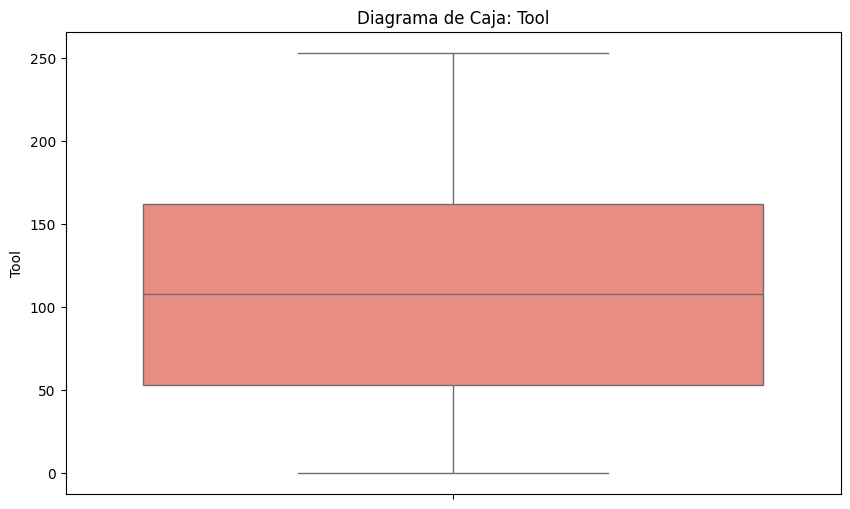

In [192]:
# Crear un boxplot para visualizar valores atípicos  tool weear (Corregir)
plt.figure(figsize=(10, 6))
sns.boxplot(y=data['Tool wear [min]'], color='salmon')
plt.title('Diagrama de Caja: Tool')
plt.ylabel('Tool')
plt.show()

*Sin valores atipicos*

## **Limpieza de datos**

### *Valores Nulos*

Verificamos que no haya valores nulos en nuestro dataset.

In [193]:
data.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

Al no contar con valores nulos no es necesario hacer imputacion o eliminacion de columnas.

### *Eliminar columnar Irrelevantes o Innecesarias.*

Eliminamos columnas que no ocuparemos

In [194]:
data = data.drop(columns=["UDI", "Product ID"])

# Mostramos como quedaria nuestro dataset
data.head()

Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0    M                298.1                    308.6                  1551.0   
1    L                298.2                    308.7                  1408.0   
2    L                298.1                    308.5                  1498.0   
3    L                298.2                    308.6                  1433.0   
4    L                298.2                    308.7                  1408.0   

   Torque [Nm]  Tool wear [min]  Target Failure Type  
0         42.8                0       0   No Failure  
1         46.3                3       0   No Failure  
2         49.4                5       0   No Failure  
3         39.5                7       0   No Failure  
4         40.0                9       0   No Failure

## **Preprocesamiento de Datos.**

### Mapeo de Nuestro Targets

En esta seccion corta lo que estamos haciendo es mapear nuestros targets para que los modelos puedan leerlo con mas facilidad.

PD: Ocupamos mapeo manual en lugar de usar One-HotEncoding o LabelEncoding por que se nos hace mas comodo y en nuestro caso el One-Hot no, nos serviria en nuestro caso, en el caso del LabelEncoding decidimos hacer el mapeo Manual por comidad ya que no son muchas variables categorias a mapear.

In [195]:
# Minutos de desgaste
data['Type'] = data['Type'].map({'L': 2, 'M': 3, 'H': 5})


# Aplicar Label Encoding
data['Failure Type'] = data['Failure Type'].map({
    "No Failure": 1,
    "Heat Dissipation Failure": 2,
    "Power Failure": 3,
    "Overstrain Failure": 4,
    "Tool Wear Failure": 5,
    "Random Failures": 6
})

In [196]:
data.head()

Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0     3                298.1                    308.6                  1551.0   
1     2                298.2                    308.7                  1408.0   
2     2                298.1                    308.5                  1498.0   
3     2                298.2                    308.6                  1433.0   
4     2                298.2                    308.7                  1408.0   

   Torque [Nm]  Tool wear [min]  Target  Failure Type  
0         42.8                0       0             1  
1         46.3                3       0             1  
2         49.4                5       0             1  
3         39.5                7       0             1  
4         40.0                9       0             1

## **Modelos de Regresión**

### *Análisis Exploratorio de Datos*

In [197]:
# Calcular la matriz de correlación
correlacion_matrix = data.corr()

# Extraer la correlación de las features con 'Rotational speed [rpm]'
correlacion_target = correlacion_matrix["Rotational speed [rpm]"].sort_values(ascending=False)

# Mostrar las correlaciones
correlacion_target


Rotational speed [rpm]     1.000000
Air temperature [K]        0.021305
Process temperature [K]    0.019892
Tool wear [min]            0.002496
Type                      -0.001903
Failure Type              -0.088975
Target                    -0.130467
Torque [Nm]               -0.911734
Name: Rotational speed [rpm], dtype: float64

#### HeatMap

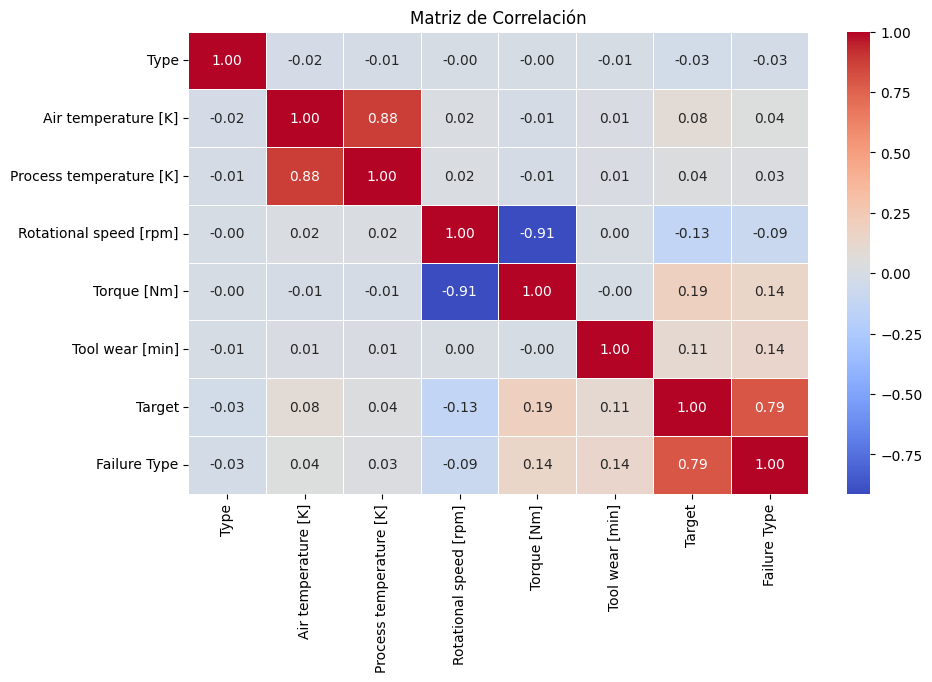

In [198]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(correlacion_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()


Podemos ver que hay algunas correlaciones muy bajas y algunas correlaciones negativas la cual ocuparemos para modificar las features que ocuparemos.

Torque [Nm]: -0.911734 (correlación negativa fuerte)

Air temperature [K]: 0.021305 (correlación muy baja)

Process temperature [K]: 0.019892 (correlación muy baja)

### *Preparación y Preprocesamiento de Datos*

#### Seleccion y división de features

In [199]:
# Variables independientes (características)
X_regresion = data[['Torque [Nm]', 'Air temperature [K]', 'Process temperature [K]']]

# Variable dependiente (objetivo)
y_regresion = data['Rotational speed [rpm]']

#### Escalado de Datos


Escalamos los datos para que nuestros modelos puedan leerlo de una manera mas sencilla.

En nuestro caso utilizaremos conforme nos de mejor precision nuestro modelos entre MinMaxScaler y StandarScaler

In [200]:
# Creamos una instancia para escalar con Min-Max
scaler_min_max_r = MinMaxScaler()
# Creamos una instancia para escalar con Min-Max
scaler_standar_r = StandardScaler() # Este es el que ocuparemos

# Ajustar y transformar los datos
X_escalado_min_max_r = scaler_min_max_r.fit_transform(X_regresion)  # X es el conjunto de datos y esta escalado con MinMaxScaler()
X_escalado_standar_r = scaler_standar_r.fit_transform(X_regresion)  # X es el conjunto de datos y esta escalado con StandardScaler()

#### Division de data

Insertamos nuestros datos escalados y luego dividimos dichos datos conforme vayamos probando la precision.

In [201]:
# Dividir los datos en entrenamiento (70%) y prueba (30%)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_escalado_standar_r, y_regresion, test_size=0.3, random_state=42)

### *Instancia y creacion del modelo*

In [202]:
# Modelo de regresion con RandomForestRegressor

model_rf_r = RandomForestRegressor(
    n_estimators=400,      # Aumentamos el número de árboles para mejorar la estabilidad
    max_depth=5,           # Reducimos la profundidad para evitar overfitting
    min_samples_split=20,  # Requiere más muestras para hacer una división
    min_samples_leaf=10,   # Cada hoja debe tener al menos 10 muestras
    max_features=0.7,      # Reducimos el número de características usadas por árbol
    random_state=42
)

# Modelo de regresion con XGBRegressor

model_xgb_r = XGBRegressor(
    n_estimators=500,   # Mantiene el número de árboles
    learning_rate=0.05,  # Velocidad de aprendizaje moderada
    max_depth=1,        # Aumenta ligeramente la profundidad para captar más patrones
    reg_lambda=10,       # Regularización L2 (reduce pesos grandes)
    reg_alpha=5,      # Regularización L1 (elimina pesos innecesarios)
    subsample=0.8,      # Usa el 80% de los datos por árbol
    colsample_bytree=0.8, # Usa el 80% de las características en cada árbol
    random_state=42
)

# Modelo de regresion con GradientBoostingRegressor

model_gb_r = GradientBoostingRegressor(
    n_estimators=400,              # Incrementa el número de árboles
    max_depth=5,                    # Mantén la profundidad moderada
    learning_rate=0.01,             # Reduce la tasa de aprendizaje
    random_state=42,                # Semilla aleatoria para reproducibilidad
    min_samples_split=20,           # Aumenta el número mínimo de muestras para dividir
    min_samples_leaf=10,            # Aumenta el número mínimo de muestras en cada hoja
    subsample=0.8,                  # Usa el 80% de los datos para cada árbol
    max_features="sqrt"             # Usa la raíz cuadrada de las características
)

En este caso tambien agregamos otros hiperparametros como regulizacion, tiempo de entrenamiento, etc.
Para que almenos ligeramente

### *Entrenamiento del modelo*

Entrenamos nuestro modelo con los datos divididos en nuetros caso un 70% de entrenamiento tanto de X y Y

In [203]:
# Entrenamos el modelo con RandomForestRegressor
model_rf_r.fit(X_train_r, y_train_r)

RandomForestRegressor(max_depth=5, max_features=0.7, min_samples_leaf=10,
                      min_samples_split=20, n_estimators=400, random_state=42)

In [204]:
# Entrenamos el modelo con XGBRegressor
model_xgb_r.fit(X_train_r, y_train_r)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [205]:
# Entrenamos el modelo con GradientBoostingRegressor
model_gb_r.fit(X_train_r, y_train_r)

GradientBoostingRegressor(learning_rate=0.01, max_depth=5, max_features='sqrt',
                          min_samples_leaf=10, min_samples_split=20,
                          n_estimators=400, random_state=42, subsample=0.8)

### *Predicciones*

RandomForestRegressor

In [206]:
# Predicción Test con Random Forest
y_test_pred_rf_r = model_rf_r.predict(X_test_r)
# Predicción Entrenamiento
y_train_pred_rf_r = model_rf_r.predict(X_train_r)

XGBRegressor

In [207]:
# Predicción Test con XGBRegresor
y_test_pred_xgb_r = model_xgb_r.predict(X_test_r)
# Predicción Entrenamiento
y_train_pred_xgb_r = model_xgb_r.predict(X_train_r)

GradientBoostingRegressor

In [208]:
# Predicción Test con GradientBoostingRegressor
y_test_pred_gb_r = model_gb_r.predict(X_test_r)
# Predicción Entrenamiento
y_train_pred_gb_r = model_gb_r.predict(X_train_r)

### *Graficas*

En esta grafica veremos que tanto se separa nuestros valores de nuestro modelo. Viendo que tan preciso fue.

#### *Colores (Ignorar)*

In [209]:
colors1 = plt.cm.Blues(np.linspace(0.3, 1, 3))  # Colores de tonos azules
colors2 = plt.cm.Reds(np.linspace(0.3, 1, 3))   # Colores de tonos rojos
colors3 = plt.cm.Greens(np.linspace(0.3, 1, 3))  # Colores de tonos verdes

#### *RandomForestRegressor*

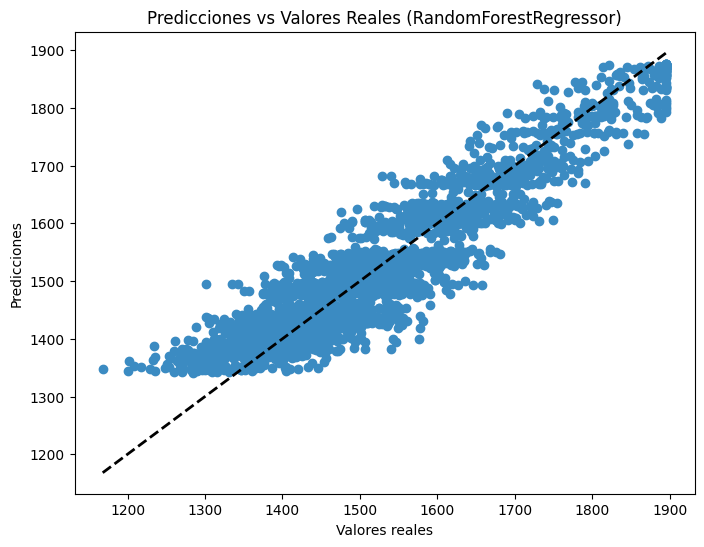

In [210]:
# Graficar las predicciones vs los valores reales de RandomForestRegressor
plt.figure(figsize=(8,6))
plt.scatter(y_test_r, y_test_pred_rf_r, color=colors1[1])
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], '--k', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales (RandomForestRegressor)')
plt.show()

#### *XGBRegressor*

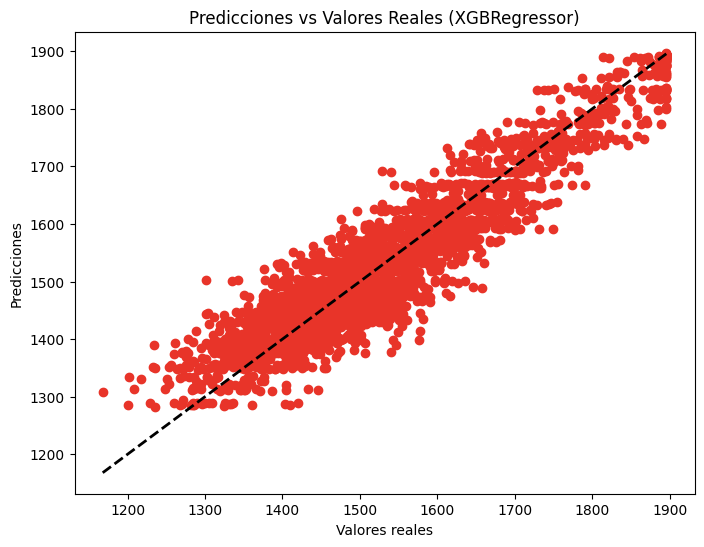

In [211]:
# Graficar las predicciones vs los valores reales de XGBRegressor
plt.figure(figsize=(8,6))
plt.scatter(y_test_r, y_test_pred_xgb_r, color=colors2[1])
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], '--k', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales (XGBRegressor)')
plt.show()

#### *GradientBoostingRegressor*

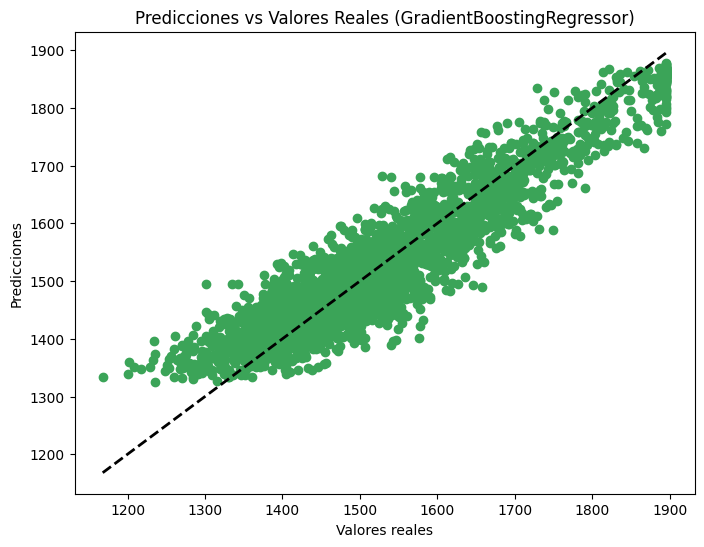

In [212]:
# Graficar las predicciones vs los valores reales de GradientBoostingRegressor
plt.figure(figsize=(8,6))
plt.scatter(y_test_r, y_test_pred_gb_r, color=colors3[1])
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], '--k', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales (GradientBoostingRegressor)')
plt.show()

### *Metricas*

Ahora utilizaremos metricas como MAE, MSE, RMSE y R2 para saber que tanto se equivoca nuestro modelo, si es que tenemos errores grandes y la "precision" de nuestro modelo.

#### *RandomForestRegressor*

In [213]:
# Cálculo de métricas para entrenamiento
mae_train_xgb_r = mean_absolute_error(y_train_r, y_train_pred_xgb_r)
mse_train_xgb_r = mean_squared_error(y_train_r, y_train_pred_xgb_r)
rmse_train_xgb_r = np.sqrt(mse_train_xgb_r)
r2_train_xgb_r = r2_score(y_train_r, y_train_pred_xgb_r)

# Cálculo de métricas para prueba
mae_test_xgb_r = mean_absolute_error(y_test_r, y_test_pred_xgb_r)
mse_test_xgb_r = mean_squared_error(y_test_r, y_test_pred_xgb_r)
rmse_test_xgb_r = np.sqrt(mse_test_xgb_r)
r2_test_xgb_r = r2_score(y_test_r, y_test_pred_xgb_r)

# Imprimir el reporte
print("Reporte de Evaluación del Modelo de Regresión:")
print("Entrenamiento:")
print(f"  MAE: {mae_train_xgb_r:.4f}")
print(f"  MSE: {mse_train_xgb_r:.4f}")
print(f"  RMSE: {rmse_train_xgb_r:.4f}")
print(f"  R^2 Score: {r2_train_xgb_r:.4f}")

print("\nPrueba:")
print(f"  MAE: {mae_test_xgb_r:.4f}")
print(f"  MSE: {mse_test_xgb_r:.4f}")
print(f"  RMSE: {rmse_test_xgb_r:.4f}")
print(f"  R^2 Score: {r2_test_xgb_r:.4f}")

Reporte de Evaluación del Modelo de Regresión:
Entrenamiento:
  MAE: 38.0690
  MSE: 2338.4352
  RMSE: 48.3574
  R^2 Score: 0.8946

Prueba:
  MAE: 39.1466
  MSE: 2495.8933
  RMSE: 49.9589
  R^2 Score: 0.8867


#### *XGBRegressor*

In [214]:
# Cálculo de métricas para entrenamiento
mae_train_rf_r = mean_absolute_error(y_train_r, y_train_pred_rf_r)
mse_train_rf_r = mean_squared_error(y_train_r, y_train_pred_rf_r)
rmse_train_rf_r = np.sqrt(mse_train_rf_r)
r2_train_rf_r = r2_score(y_train_r, y_train_pred_rf_r)

# Cálculo de métricas para prueba
mae_test_rf_r = mean_absolute_error(y_test_r, y_test_pred_rf_r)
mse_test_rf_r = mean_squared_error(y_test_r, y_test_pred_rf_r)
rmse_test_rf_r = np.sqrt(mse_test_rf_r)
r2_test_rf_r = r2_score(y_test_r, y_test_pred_rf_r)

# Imprimir el reporte
print("Reporte de Evaluación del Modelo de Regresión:")
print("Entrenamiento:")
print(f"  MAE: {mae_train_rf_r:.4f}")
print(f"  MSE: {mse_train_rf_r:.4f}")
print(f"  RMSE: {rmse_train_rf_r:.4f}")
print(f"  R^2 Score: {r2_train_rf_r:.4f}")

print("\nPrueba:")
print(f"  MAE: {mae_test_rf_r:.4f}")
print(f"  MSE: {mse_test_rf_r:.4f}")
print(f"  RMSE: {rmse_test_rf_r:.4f}")
print(f"  R^2 Score: {r2_test_rf_r:.4f}")

Reporte de Evaluación del Modelo de Regresión:
Entrenamiento:
  MAE: 39.1591
  MSE: 2406.6995
  RMSE: 49.0581
  R^2 Score: 0.8915

Prueba:
  MAE: 40.3533
  MSE: 2578.7137
  RMSE: 50.7810
  R^2 Score: 0.8829


#### *GradientBoostingRegressor*

In [215]:
# Cálculo de métricas para entrenamiento
mae_train_gbm_r = mean_absolute_error(y_train_r, y_train_pred_gb_r)
mse_train_gbm_r = mean_squared_error(y_train_r, y_train_pred_gb_r)
rmse_train_gbm_r = np.sqrt(mse_train_gbm_r)
r2_train_gbm_r = r2_score(y_train_r, y_train_pred_gb_r)

# Cálculo de métricas para prueba
mae_test_gbm_r = mean_absolute_error(y_test_r, y_test_pred_gb_r)
mse_test_gbm_r = mean_squared_error(y_test_r, y_test_pred_gb_r)
rmse_test_gbm_r = np.sqrt(mse_test_gbm_r)
r2_test_gbm_r = r2_score(y_test_r, y_test_pred_gb_r)

# Imprimir el reporte
print("Reporte de Evaluación del Modelo de Regresión:")
print("Entrenamiento:")
print(f"  MAE: {mae_train_gbm_r:.4f}")
print(f"  MSE: {mse_train_gbm_r:.4f}")
print(f"  RMSE: {rmse_train_gbm_r:.4f}")
print(f"  R^2 Score: {r2_train_gbm_r:.4f}")

print("\nPrueba:")
print(f"  MAE: {mae_test_gbm_r:.4f}")
print(f"  MSE: {mse_test_gbm_r:.4f}")
print(f"  RMSE: {rmse_test_gbm_r:.4f}")
print(f"  R^2 Score: {r2_test_gbm_r:.4f}")

Reporte de Evaluación del Modelo de Regresión:
Entrenamiento:
  MAE: 38.3935
  MSE: 2292.5130
  RMSE: 47.8802
  R^2 Score: 0.8966

Prueba:
  MAE: 40.9753
  MSE: 2626.4062
  RMSE: 51.2485
  R^2 Score: 0.8808


### *Votacion Suave*

In [216]:
from sklearn.ensemble import VotingRegressor

# Crear el modelo de votación suave
model_votacion_suave_r = VotingRegressor(estimators=[
    ('rf', model_rf_r),
    ('xgb', model_xgb_r),
    ('gbr', model_gb_r)
])

# Entrenamiento
model_votacion_suave_r.fit(X_train_r, y_train_r)

# Predicción en el conjunto de entrenamiento y prueba
predicciones_train_vs_r = model_votacion_suave_r.predict(X_train_r)
predicciones_test_vs_r = model_votacion_suave_r.predict(X_test_r)

# Calcular las métricas para el conjunto de entrenamiento
mae_train_vs_r = mean_absolute_error(y_train_r, predicciones_train_vs_r)
mse_train_vs_r = mean_squared_error(y_train_r, predicciones_train_vs_r)
rmse_train_vs_r = np.sqrt(mse_train_vs_r)
r2_train_vs_r = r2_score(y_train_r, predicciones_train_vs_r)

# Calcular las métricas para el conjunto de prueba
mae_test_vs_r = mean_absolute_error(y_test_r, predicciones_test_vs_r)
mse_test_vs_r = mean_squared_error(y_test_r, predicciones_test_vs_r)
rmse_test_vs_r = np.sqrt(mse_test_vs_r)
r2_test_vs_r = r2_score(y_test_r, predicciones_test_vs_r)

# Imprimir el reporte
print("Reporte de Evaluación del Modelo de Votación Suave:")

# Métricas de Entrenamiento
print("\nEntrenamiento:")
print(f"  MAE: {mae_train_vs_r:.4f}")
print(f"  MSE: {mse_train_vs_r:.4f}")
print(f"  RMSE: {rmse_train_vs_r:.4f}")
print(f"  R^2 Score: {r2_train_vs_r:.4f}")

# Métricas de Prueba
print("\nPrueba:")
print(f"  MAE: {mae_test_vs_r:.4f}")
print(f"  MSE: {mse_test_vs_r:.4f}")
print(f"  RMSE: {rmse_test_vs_r:.4f}")
print(f"  R^2 Score: {r2_test_vs_r:.4f}")

Reporte de Evaluación del Modelo de Votación Suave:

Entrenamiento:
  MAE: 38.2871
  MSE: 2308.1421
  RMSE: 48.0431
  R^2 Score: 0.8959

Prueba:
  MAE: 39.9073
  MSE: 2529.0891
  RMSE: 50.2900
  R^2 Score: 0.8852


## **Modelo Clasificación**

### Seleccion y división de features

In [217]:
# Separamos nuestro target de nuestras features para hacerle smote por separado.
x_clasificacion_uno_rf = data.drop(columns=['Failure Type', 'Target'])
y_clasificacion_uno_rf = data['Target']  # Variable objetivo | No Failure: 0 / Failure:1

### Smote

In [218]:
# Aplicar SMOTE
smote_uno_rf = SMOTE(sampling_strategy='auto', random_state=42)
x_resampled_uno_rf, y_resampled_uno_rf = smote_uno_rf.fit_resample(x_clasificacion_uno_rf, y_clasificacion_uno_rf)

# Convertir de nuevo a DataFrame
data_resampled_uno_rf = pd.DataFrame(x_resampled_uno_rf, columns=x_clasificacion_uno_rf.columns)
data_resampled_uno_rf['Target'] = y_resampled_uno_rf

# Verificar el balance después de aplicar SMOTE
print(data_resampled_uno_rf['Target'].value_counts())

# Variables a ocupar para el smote
x_clasificacion_smote_uno_rf = data_resampled_uno_rf.drop(columns=['Target'])
y_clasificacion_smote_uno_rf = data_resampled_uno_rf['Target']

Target
0    9661
1    9661
Name: count, dtype: int64


### **Division de data**

In [219]:
# Dividir los datos en conjunto de entrenamiento y prueba en 70% de entrenamiento y 30% prueba
X_train_c_uno, X_test_c_uno, y_train_c_uno, y_test_c_uno = train_test_split(
    x_clasificacion_smote_uno_rf, y_clasificacion_smote_uno_rf, test_size=0.3, random_state=42
)

### *Instancia y creación del modelo*

In [220]:
# Crear el modelo Random Forest utilizando "Target como Objetivo"
modelo_rf_c_uno = RandomForestClassifier(
    n_estimators=75,   # Reduce el número de árboles
    max_depth=10,      # Limita la profundidad de los árboles
    min_samples_split=5,  # Evita divisiones con muy pocos datos
    min_samples_leaf=3,   # Cada hoja debe tener al menos 3 muestras
    max_features='sqrt',  # Reduce las características usadas en cada división
    random_state=42
)

### *Entrenamiento del modelo*

In [221]:
# Entrenar el modelo
modelo_rf_c_uno.fit(X_train_c_uno, y_train_c_uno)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=5,
                       n_estimators=75, random_state=42)

### *Predicciones*

In [222]:
# Predecir con el modelo en entrenamiento y prueba
y_train_pred_c_uno = modelo_rf_c_uno.predict(X_train_c_uno)
y_test_pred_c_uno = modelo_rf_c_uno.predict(X_test_c_uno)

### *Metricas*

In [223]:
# Evaluar el modelo en entrenamiento
accuracy_train_c_uno = accuracy_score(y_train_c_uno, y_train_pred_c_uno)
print("Entrenamiento:")
print(f"  Accuracy: {accuracy_train_c_uno:.4f}")
print(classification_report(y_train_c_uno, y_train_pred_c_uno))

# Evaluar el modelo en prueba
accuracy_test_c_uno = accuracy_score(y_test_c_uno, y_test_pred_c_uno)
print("\nPrueba:")
print(f"  Accuracy: {accuracy_test_c_uno:.4f}")
print(classification_report(y_test_c_uno, y_test_pred_c_uno))

Entrenamiento:
  Accuracy: 0.9692
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      6760
           1       0.96      0.98      0.97      6765

    accuracy                           0.97     13525
   macro avg       0.97      0.97      0.97     13525
weighted avg       0.97      0.97      0.97     13525


Prueba:
  Accuracy: 0.9584
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2901
           1       0.94      0.98      0.96      2896

    accuracy                           0.96      5797
   macro avg       0.96      0.96      0.96      5797
weighted avg       0.96      0.96      0.96      5797



### Grafica

### Curva de aprendizaje

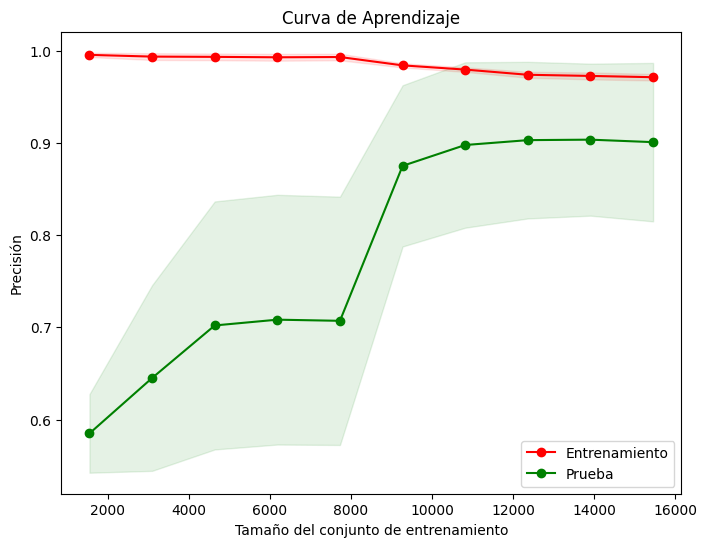

In [224]:
from sklearn.model_selection import learning_curve

# Curva de aprendizaje
def plot_learning_curve(model, x_clasificacion_smote, y_clasificacion_smote):
    train_sizes, train_scores, test_scores = learning_curve(model, x_clasificacion_smote, y_clasificacion_smote, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Entrenamiento")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Prueba")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

    plt.xlabel("Tamaño del conjunto de entrenamiento")
    plt.ylabel("Precisión")
    plt.title("Curva de Aprendizaje")
    plt.legend()
    plt.show()

# Generar la curva de aprendizaje
plot_learning_curve(modelo_rf_c_uno, x_clasificacion_smote_uno_rf, y_clasificacion_smote_uno_rf)

## **Clasificacion - 2**

### Seleccion y división de features

In [225]:
# Separamos nuestro target de nuestras features para hacerle smote por separado.
x_clasificacion_dos_rf = data.drop(columns=['Failure Type', 'Target'])
y_clasificacion_dos_rf = data['Failure Type']  # Variable objetivo

# Donde las siguientes variables se mapearon quedando de tal forma.
"""
    "No Failure": 1,
    "Heat Dissipation Failure": 2,
    "Power Failure": 3,
    "Overstrain Failure": 4,
    "Tool Wear Failure": 5,
    "Random Failures": 6

"""

'\n    "No Failure": 1,\n    "Heat Dissipation Failure": 2,\n    "Power Failure": 3,\n    "Overstrain Failure": 4,\n    "Tool Wear Failure": 5,\n    "Random Failures": 6\n\n'

### Smote

In [226]:
# Aplicar SMOTE
smote_dos_rf = SMOTE(sampling_strategy='auto', random_state=42)
x_resampled_dos_rf, y_resampled_dos_rf = smote_dos_rf.fit_resample(x_clasificacion_dos_rf, y_clasificacion_dos_rf)

# Convertir de nuevo a DataFrame
data_resampled_dos_rf = pd.DataFrame(x_resampled_dos_rf, columns=x_clasificacion_dos_rf.columns)
data_resampled_dos_rf['Target'] = y_resampled_dos_rf

# Verificar el balance después de aplicar SMOTE
print(data_resampled_dos_rf['Target'].value_counts())


x_clasificacion_smote_dos_rf = data_resampled_dos_rf.drop(columns=['Target'])
y_clasificacion_smote_dos_rf = data_resampled_dos_rf['Target']

Target
1    9652
3    9652
5    9652
4    9652
6    9652
2    9652
Name: count, dtype: int64


### **Division de data**

In [227]:
# Dividir los datos en conjunto de entrenamiento y prueba
X_train_c_dos, X_test_c_dos, y_train_c_dos, y_test_c_dos = train_test_split(
    x_clasificacion_smote_dos_rf, y_clasificacion_smote_dos_rf, test_size=0.3, random_state=42
)

### *Instancia y creación del modelo*

In [228]:
# Crear el modelo Random Forest
modelo_rf_c_dos = RandomForestClassifier(
    n_estimators=75,   # Reduce el número de árboles
    max_depth=10,      # Limita la profundidad de los árboles
    min_samples_split=5,  # Evita divisiones con muy pocos datos
    min_samples_leaf=3,   # Cada hoja debe tener al menos 3 muestras
    max_features='sqrt',  # Reduce las características usadas en cada división
    random_state=42
)

### *Entrenamiento del modelo*

In [229]:
# Entrenar el modelo
modelo_rf_c_dos.fit(X_train_c_dos, y_train_c_dos)


RandomForestClassifier(max_depth=10, min_samples_leaf=3, min_samples_split=5,
                       n_estimators=75, random_state=42)

### *Predicciones*

In [230]:
# Predecir con el modelo en entrenamiento y prueba
y_train_pred_c_rf_dos = modelo_rf_c_dos.predict(X_train_c_dos)
y_test_pred_c_rf_dos = modelo_rf_c_dos.predict(X_test_c_dos)

### *Metricas*

In [231]:
# Evaluar el modelo en entrenamiento
accuracy_train_c_dos = accuracy_score(y_train_c_dos, y_train_pred_c_rf_dos)
print("Entrenamiento:")
print(f"  Accuracy: {accuracy_train_c_dos:.4f}")
print(classification_report(y_train_c_dos, y_train_pred_c_rf_dos))

# Evaluar el modelo en prueba
accuracy_test_c_dos = accuracy_score(y_test_c_dos, y_test_pred_c_rf_dos)
print("\nPrueba:")
print(f"  Accuracy: {accuracy_test_c_dos:.4f}")
print(classification_report(y_test_c_dos, y_test_pred_c_rf_dos))


Entrenamiento:
  Accuracy: 0.9680
              precision    recall  f1-score   support

           1       0.99      0.83      0.90      6686
           2       0.99      1.00      1.00      6801
           3       1.00      1.00      1.00      6803
           4       0.99      1.00      0.99      6714
           5       0.95      0.99      0.97      6773
           6       0.90      0.98      0.94      6761

    accuracy                           0.97     40538
   macro avg       0.97      0.97      0.97     40538
weighted avg       0.97      0.97      0.97     40538


Prueba:
  Accuracy: 0.9624
              precision    recall  f1-score   support

           1       0.98      0.81      0.89      2966
           2       0.99      1.00      0.99      2851
           3       0.99      1.00      1.00      2849
           4       0.98      1.00      0.99      2938
           5       0.94      0.99      0.97      2879
           6       0.90      0.97      0.93      2891

    accuracy   

### Grafica

### Curva de Aprendizaje

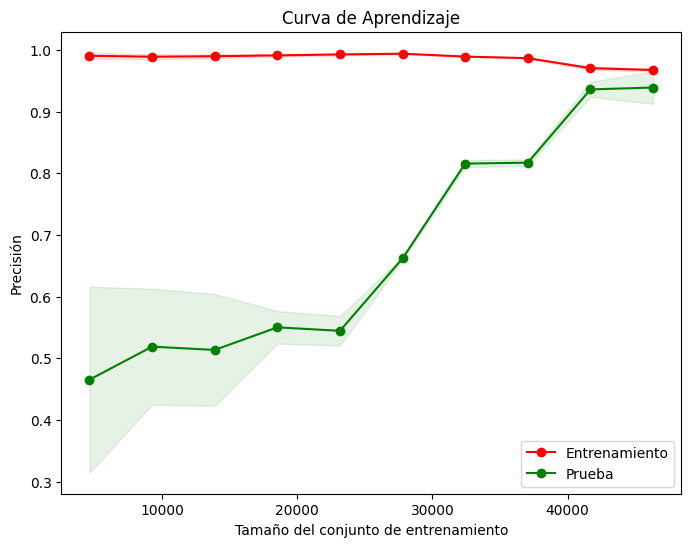

In [232]:
from sklearn.model_selection import learning_curve

# Curva de aprendizaje
def plot_learning_curve(model, x_clasificacion_smote, y_clasificacion_smote):
    train_sizes, train_scores, test_scores = learning_curve(model, x_clasificacion_smote, y_clasificacion_smote, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Entrenamiento")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Prueba")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

    plt.xlabel("Tamaño del conjunto de entrenamiento")
    plt.ylabel("Precisión")
    plt.title("Curva de Aprendizaje")
    plt.legend()
    plt.show()

# Generar la curva de aprendizaje
plot_learning_curve(modelo_rf_c_dos, x_clasificacion_smote_dos_rf, y_clasificacion_smote_dos_rf)

## Modelo Clustering

In [233]:
# Seleccionar características numéricas relevantes
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
X = data[features]

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [234]:
from sklearn.decomposition import PCA
# Reducir la dimensionalidad con PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Mostrar las cargas (componentes principales)
pca_components = pd.DataFrame(pca.components_, columns=X.columns, index=['PC1', 'PC2', 'PC3'])
print("Cargas de las Componentes Principales:")
print(pca_components)

# Mostrar la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_
print("\nVarianza Explicada por Componente:")
print(explained_variance)

Cargas de las Componentes Principales:
     Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
PC1             0.370281                 0.369950                0.603724   
PC2             0.602200                 0.602404               -0.368031   
PC3            -0.015282                -0.015696               -0.002976   

     Torque [Nm]  Tool wear [min]  
PC1    -0.601113         0.014489  
PC2     0.372471         0.016809  
PC3     0.002036         0.999754  

Varianza Explicada por Componente:
[0.38662133 0.37103922 0.19991253]


In [235]:
data['Failure Type'].value_counts()

Failure Type
1    9652
2     112
3      95
4      78
5      45
6      18
Name: count, dtype: int64

    "No Failure": 1
    "Heat Dissipation Failure": 2
    "Power Failure": 3
    "Overstrain Failure": 4
    "Tool Wear Failure": 5
    "Random Failures": 6

PCA Sirve para desglosar o redimensionar el data para que sea mas pequeño, reducir el ruido y sacar una correlacion

*   PC1 separa los datos en función de la velocidad de rotación y el torque.
*   PC2 refleja principalmente diferencias en las temperaturas.
*   PC3 está casi completamente relacionada con el desgaste de la herramienta.

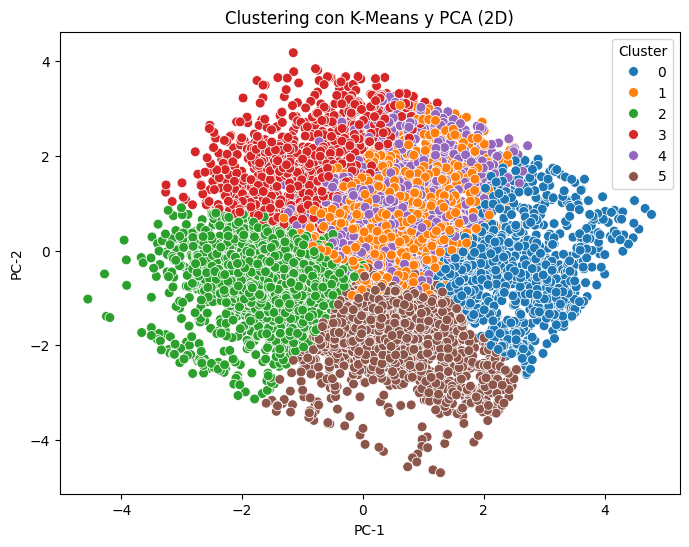

0    1021
1    1725
2    2574
3    1267
4    1770
5    1643
Name: count, dtype: int64

In [236]:
# Aplicar K-Means con 6 clusters
from sklearn.cluster import KMeans # Import the KMeans class from sklearn.cluster
kmeans = KMeans(n_clusters=6, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

# Visualizar los resultados usando PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_kmeans, palette='tab10', s=50)
plt.title('Clustering con K-Means y PCA (2D)')
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.legend(title='Cluster')
plt.show()

# Mostrar la distribución de puntos por cluster
cluster_distribution = pd.Series(labels_kmeans).value_counts().sort_index()
cluster_distribution

*   PC1 separa los datos en función de la velocidad de rotación y el torque.
*   PC2 refleja principalmente diferencias en las temperaturas.
*   PC3 está casi completamente relacionada con el desgaste de la herramienta.

In [237]:
import plotly.graph_objects as go

# Convertir a DataFrame para facilitar la manipulación
df = pd.DataFrame(X_pca, columns=['Componente Principal 1', 'Componente Principal 2', 'Componente Principal 3'])
df['Cluster'] = labels_kmeans

palette = sns.color_palette("tab10", n_colors=6)
colors = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for r, g, b in palette]

# Crear la figura 3D
fig = go.Figure()

# Agregar puntos para cada cluster
for cluster in range(6):
    cluster_data = df[df['Cluster'] == cluster]
    fig.add_trace(go.Scatter3d(
        x=cluster_data['Componente Principal 1'],
        y=cluster_data['Componente Principal 2'],
        z=cluster_data['Componente Principal 3'],
        mode='markers',
        marker=dict(size=4, color=colors[cluster]),
        name=f'Cluster {cluster}'
    ))

# Configurar diseño
fig.update_layout(
    title='Clustering con K-Means y PCA (3D)',
    scene=dict(
        xaxis_title='Componente Principal 1',
        yaxis_title='Componente Principal 2',
        zaxis_title='Componente Principal 3'
    ),
    legend_title='Cluster'
)

# Mostrar la figura interactiva
fig.show()


*   PC1 separa los datos en función de la velocidad de rotación y el torque.
*   PC2 refleja principalmente diferencias en las temperaturas.
*   PC3 está casi completamente relacionada con el desgaste de la herramienta.